### Goal of this notebook is to see if the implemented gcp stroke model and the stroke phenotype models are reasonable, meaningful. This notebook runs a simulation and analyzes results.

In [1]:
import os
import csv
import pandas as pd
from pandarallel import pandarallel
import multiprocessing as mp
import numpy as np

from microsim.population import NHANESDirectSamplePopulation
from microsim.sim_settings import simSettings
from microsim.outcome import OutcomeType

pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = False #with this flag all new population instances will be set to use pandarallel

seedSequence = np.random.SeedSequence()
rngStream = np.random.default_rng(seed=seedSequence)

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

popSize = 50000
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
alive, df = pop.advance_vectorized(150, rng=rngStream)


In [ ]:
#alive[["gcp","baseGcp", "gcp0", "gcp1", "gcp2", "gcp3", "gcp4","gcp5","meanGcp"]].head()

In [2]:
import matplotlib.pyplot as plt
from microsim.stroke_outcome import StrokeOutcome, StrokeSubtype, StrokeType

In [3]:
popIndexWithStroke = []
popIndexWithMoreThanOneStroke = []
for popIndex in range(popSize):
    if pop._people.iloc[popIndex]._stroke:
        popIndexWithStroke += [popIndex]
        if len(pop._people.iloc[popIndex]._outcomes[OutcomeType.STROKE])>1:
            popIndexWithMoreThanOneStroke += [popIndex]
            
nihssList = []
for indexWithStroke in popIndexWithStroke:
    for strokeOutcome in pop._people.iloc[indexWithStroke]._outcomes[OutcomeType.STROKE]:
        nihssList += [strokeOutcome[1].properties["nihss"]]
        
strokeTypeList = []
for indexWithStroke in popIndexWithStroke:
    for strokeOutcome in pop._people.iloc[indexWithStroke]._outcomes[OutcomeType.STROKE]:
        strokeTypeList += [strokeOutcome[1].properties["strokeType"]]
        
strokeSubtypeList = []
for indexWithStroke in popIndexWithStroke:
    for strokeOutcome in pop._people.iloc[indexWithStroke]._outcomes[OutcomeType.STROKE]:
        strokeSubtypeList += [strokeOutcome[1].properties["strokeSubtype"]]
        
strokePhenotypes = {"nihss": nihssList, "strokeType": strokeTypeList, "strokeSubtype": strokeSubtypeList}
strokePhenotypesDF = pd.DataFrame(strokePhenotypes)
gcpDict = dict()
for i in range(popSize):
    gcpDict[i] = np.array(pop._people.iloc[i]._gcp)
gcpDF = pd.DataFrame( dict([ (k,pd.Series(v)) for k,v in gcpDict.items() ]))
age0DF = pd.DataFrame( dict( [ (x._populationIndex, [x._age[0]]) for x in pop._people ] ), ["age0"])
maxNStrokes = max([ len(x._outcomes[OutcomeType.STROKE]) for x in pop._people ])
strokeAgesDict = dict()
for j in range(popSize):
    x = pop._people.iloc[j]
    strokeAgesDict[j] = np.array( [x._outcomes[OutcomeType.STROKE][i][0] for i in range(len(x._outcomes[OutcomeType.STROKE]))] )
strokeAgesDF = pd.DataFrame( dict( [(k,pd.Series(v)) for k,v in strokeAgesDict.items() ]) )
strokeAgesDF.index = [f"stroke{x}Age" for x in range(maxNStrokes)]
dataDF = pd.concat([gcpDF, age0DF, strokeAgesDF])

In [4]:
data = dataDF
data.head()

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
0,68.391158,66.669910,60.811825,60.059288,53.490633,66.634348,47.293387,46.016855,63.594022,46.860314,...,58.306538,47.284205,68.590912,57.029365,64.075198,59.893019,49.201159,70.360679,72.020100,67.017425
1,68.207643,57.277894,65.745414,73.686301,61.275361,65.543400,50.331013,42.654658,82.324510,52.357438,...,60.359117,65.202761,55.359067,52.884930,61.915595,68.338777,62.090986,61.115823,64.348515,77.387249
2,76.078133,58.728785,59.933599,55.090038,56.526805,64.589550,40.138062,50.848692,59.400458,49.090219,...,36.656093,52.295924,64.059538,62.373119,54.847559,59.983904,44.163822,56.326106,60.138025,77.212089
3,58.433790,58.547443,66.330509,75.897609,70.887828,57.506156,59.071127,46.263421,59.675137,37.689533,...,62.757896,55.366603,56.491215,55.068070,50.239446,70.807245,57.990220,61.788552,70.700866,60.606232
4,62.230972,74.182376,60.300530,53.665477,48.596338,61.213973,52.417085,36.783746,59.832411,47.555601,...,44.265067,56.998830,60.138282,55.071247,51.845742,60.649151,37.517367,66.739545,66.453611,59.469901


In [5]:
strokePhenotype = strokePhenotypesDF
strokePhenotype.head()

,nihss,strokeType,strokeSubtype
0,6.0,StrokeType.ICH,StrokeSubtype.CARDIOEMBOLIC
1,6.0,StrokeType.ICH,StrokeSubtype.OTHER
2,3.0,StrokeType.ISCHEMIC,StrokeSubtype.OTHER
3,6.0,StrokeType.ISCHEMIC,StrokeSubtype.CARDIOEMBOLIC
4,7.0,StrokeType.ICH,StrokeSubtype.CARDIOEMBOLIC


In [6]:
maxWave = data[:"age0"].shape[0]-1
maxWave

91

In [7]:
strokePhenotypeLabels = {StrokeSubtype.CARDIOEMBOLIC:"CE", StrokeSubtype.SMALL_VESSEL:"SV", 
                         StrokeSubtype.OTHER:"OTHER", StrokeSubtype.LARGE_VESSEL:"LV",
                         StrokeType.ISCHEMIC:"ISC", StrokeType.ICH:"ICH"}

In [8]:
strokePhenotype["strokeSubtypeLabels"]=strokePhenotype["strokeSubtype"].replace(strokePhenotypeLabels)
strokePhenotype["strokeTypeLabels"]=strokePhenotype["strokeType"].replace(strokePhenotypeLabels)

In [9]:
strokePhenotype.head()

,nihss,strokeType,strokeSubtype,strokeSubtypeLabels,strokeTypeLabels
0,6.0,StrokeType.ICH,StrokeSubtype.CARDIOEMBOLIC,CE,ICH
1,6.0,StrokeType.ICH,StrokeSubtype.OTHER,OTHER,ICH
2,3.0,StrokeType.ISCHEMIC,StrokeSubtype.OTHER,OTHER,ISC
3,6.0,StrokeType.ISCHEMIC,StrokeSubtype.CARDIOEMBOLIC,CE,ISC
4,7.0,StrokeType.ICH,StrokeSubtype.CARDIOEMBOLIC,CE,ICH


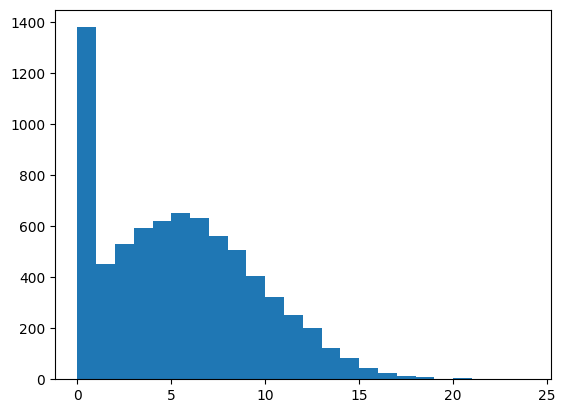

In [21]:
plt.hist(strokePhenotype["nihss"],bins=[x for x in range(0,25)])
plt.show()

In [23]:
strokePhenotype["nihss"].describe()

count    7415.000000
mean        5.031423
std         3.997094
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max        24.000000
Name: nihss, dtype: float64

In [24]:
strokePhenotype["nihss"].quantile(q=0.9)

11.0

In [ ]:
plt.hist(strokePhenotype["strokeTypeLabels"])
plt.show()

In [ ]:
plt.hist(strokePhenotype["strokeSubtypeLabels"])
plt.show()

In [ ]:
data.loc["stroke0Wave"] = data.loc["stroke0Age"] - data.loc["age0"].astype('int')

In [ ]:
def get_prestroke_gcp(x):
    return  ([None] #[np.array([None for i in range(maxWave)])] 
            if pd.isna(x["stroke0Wave"]) 
            else [np.array(x.iloc[:x["stroke0Wave"].astype('int')+1])])

def get_poststroke_gcp(x):
    return ([None] #[np.array([None for i in range(maxWave)])] 
            if pd.isna(x["stroke0Wave"]) 
            else [np.array(x.iloc[x["stroke0Wave"].astype('int')+1:maxWave])])

In [ ]:
gcpPreStroke0 = data.apply(get_prestroke_gcp)
gcpPreStroke0.index=["gcpPreStroke0"]
gcpPostStroke0 = data.apply(get_poststroke_gcp)
gcpPostStroke0.index = ["gcpPostStroke0"]
data=pd.concat([data,gcpPreStroke0,gcpPostStroke0])

indexWithStroke = gcpPreStroke0.notnull().loc["gcpPreStroke0"]

In [ ]:
gcpPreStroke0Series = gcpPreStroke0.loc["gcpPreStroke0",gcpPreStroke0.notnull().loc["gcpPreStroke0"]]

gcpPostStroke0Series = gcpPostStroke0.loc["gcpPostStroke0",gcpPostStroke0.notnull().loc["gcpPostStroke0"]]

In [ ]:
gcpPreStroke0DF = pd.DataFrame( dict([ (k, pd.Series(v).iloc[::-1].reset_index(drop=True)) for k,v in gcpPreStroke0Series.items() ]))
gcpPreStroke0DF.head()

In [ ]:
gcpPostStroke0DF = pd.DataFrame( dict([ (k, pd.Series(v).iloc[::1].reset_index(drop=True)) for k,v in gcpPostStroke0Series.items() ]))
gcpPostStroke0DF.head()

In [ ]:
gcpPreStroke0DF["mean"] = gcpPreStroke0DF.mean(axis=1)
gcpPostStroke0DF["mean"] = gcpPostStroke0DF.mean(axis=1)

In [ ]:
meanGcpPreStroke0 = gcpPreStroke0DF["mean"].iloc[::-1].tolist() 
meanGcpPostStroke0 = gcpPostStroke0DF["mean"].tolist()
meanGcp = meanGcpPreStroke0 + meanGcpPostStroke0 
time = [i for i in range(-len(meanGcpPreStroke0),1)] + [i for i in range(1,len(meanGcpPostStroke0))] 

In [ ]:
plt.scatter(time,meanGcp)
plt.title("mean gcp of the stroke cohort")
plt.xlabel("time (0=year of stroke)")
plt.show()